# Find Anagrams - Part 01
# Structure the data
Mike Babb  
babb.mike@outlook.com

In [1]:
# standard libraries
import collections
import string

In [2]:
# external libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# custom, user-defined functions
import _run_constants as rc
from part_00_file_db_utils import *

### set input and output paths

In [4]:
create_path(data_output_file_path=rc.DATA_OUTPUT_FILE_PATH)

\project\finding_anagrams\data exists


In [5]:
# construct the input file path using the information in the run constants
in_fpn = os.path.join(rc.IN_FILE_PATH, rc.IN_FILE_NAME)

### import list of words, shape data

In [6]:
# use pandas to load the data
# htps://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
print('...Reading in list of words...')
word_df = pd.read_csv(filepath_or_buffer=in_fpn, sep=',',
                      header=None, names=['word'])

...Reading in list of words...


In [7]:
# check the first few rows
word_df.head()

,word
0,A
1,a
2,aa
3,aal
4,aalii


In [8]:
# how many words are we working with?
n_words = len(word_df)
print('...found', '{:,}'.format(n_words), 'words to find anagrams for...')

...found 235,886 words to find anagrams for...


In [9]:
# convert the only column to a string - just to be safe.
# 'nan' is a word in the dictionary. nan is an internal python value.
# same with 'null'
word_df['word'] = word_df['word'].astype(str)

In [10]:
# create lower case values of the words
word_df['lcase'] = word_df['word'].str.lower()

In [11]:
# remove hyphens
word_df['lcase'] = word_df['lcase'].str.replace('-', '')

In [12]:
# and now drop duplicates, based on the lowercase version of each word
word_df = word_df.drop_duplicates('lcase')

In [13]:
word_df.shape

(234370, 2)

In [14]:
# Approximately 234K words. That's a lot of words.

In [15]:
# find word length
word_df['n_chars'] = word_df['lcase'].str.len()

In [16]:
# extract the first letter of each word
word_df['first_letter'] = word_df['lcase'].str[:1]

In [17]:
# create an id
word_df['word_id'] = range(0, len(word_df))

In [18]:
# add a hash id to capture the sorted letters in each word
# use map() with a lambda function to chain several operations together
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html
# as an example of what this is doing...

In [19]:
# sort
sorted('example')

['a', 'e', 'e', 'l', 'm', 'p', 'x']

In [20]:
# join individual letters into a string
''.join(sorted('example'))

'aeelmpx'

In [21]:
# combine all of the steps into
hash(''.join(sorted('example')))

-4541243685954599731

In [22]:
# now, do this for all 234K words.
word_df['hash_id'] = word_df['lcase'].map(lambda x: hash(''.join(sorted(x))))

In [23]:
word_df.head()

,word,lcase,n_chars,first_letter,word_id,hash_id
0,A,a,1,a,0,8392623377410914431
2,aa,aa,2,a,1,1862947001004379689
3,aal,aal,3,a,2,5232638623450174623
4,aalii,aalii,5,a,3,1358580059351371399
5,aam,aam,3,a,4,-2719937470045982907


In [24]:
# 234K words, but after sorting the letters in each word, there are about 216K unique words.
word_df['hash_id'].unique().shape

(215842,)

In [25]:
# what is the percentage?
word_df['hash_id'].unique().shape[0] / word_df.shape[0]

0.9209455135042881

In [26]:
# about 8% of words are in word groups

In [27]:
# create a dataframe of the unique, hashed values
word_id_hash_id_df = word_df['hash_id'].drop_duplicates().to_frame()

In [28]:
# add a unique id
word_id_hash_id_df['word_group_id'] = range(0, len(word_id_hash_id_df))

In [29]:
word_id_hash_id_df.shape

(215842, 2)

In [30]:
# create a dictionary using dictionary comprehension of the hash values using zip
# https://docs.python.org/3/library/functions.html#zip
hash_id_dict = {hash_id: word_group_id for word_group_id, hash_id in zip(
    word_id_hash_id_df['word_group_id'], word_id_hash_id_df['hash_id'])}

In [31]:
# apply the word group id to the
word_df['word_group_id'] = word_df['hash_id'].map(hash_id_dict)

In [32]:
# drop the hash id, no longer needed
word_df = word_df.drop(labels='hash_id', axis=1)

In [33]:
word_df.tail()

,word,lcase,n_chars,first_letter,word_id,word_group_id
235881,zythem,zythem,6,z,234365,215837
235882,Zythia,zythia,6,z,234366,215838
235883,zythum,zythum,6,z,234367,215839
235884,Zyzomys,zyzomys,7,z,234368,215840
235885,Zyzzogeton,zyzzogeton,10,z,234369,215841


# create dictionaries for fast look ups 

In [34]:
# use dictionary comprehension to store the letter and letter index
# of the letter for fast look ups
# we'll import the letters from string.ascii_lowercase
letter_dict = {l: li for li, l in enumerate(string.ascii_lowercase)}

In [35]:
# generate a list of letters from the string.ascii_lowercase
letters = string.ascii_lowercase

# create the letter groups

In [36]:
# get the unique letters in each word and then sort those letters
word_df['letter_group'] = word_df['lcase'].map(
    lambda x: ''.join(sorted(set(x))))

In [37]:
word_df.head()

,word,lcase,n_chars,first_letter,word_id,word_group_id,letter_group
0,A,a,1,a,0,0,a
2,aa,aa,2,a,1,1,a
3,aal,aal,3,a,2,2,al
4,aalii,aalii,5,a,3,3,ail
5,aam,aam,3,a,4,4,am


### count letter frequency

In [38]:
# several versions of the anagram determination technique require subsetting by letters in each word.
# generate those data and use a ranking technique to help with anagram group identification

In [39]:
# use a counter object to count the total occurences of each letter AND
# a counter to count the number of words that feature each letter
# counters are a special type of dictionary.
# https://docs.python.org/3/library/collections.html#collections.Counter
# very fast
total_letter_counter = collections.Counter()
single_letter_counter = collections.Counter()

# enumerate each word and then each letter
for curr_word in word_df['lcase'].to_numpy():
    total_letter_counter.update(list(curr_word))

for curr_letter_group in word_df['letter_group'].to_numpy():
    single_letter_counter.update(list(curr_letter_group))

In [40]:
# make a dataframe from the counter object
letter_count_df = pd.DataFrame.from_dict(data=total_letter_counter, orient='index', columns=[
                                         'total_letter_count']).reset_index(names=['letter'])

In [41]:
letter_count_df

,letter,total_letter_count
0,a,198359
1,l,129962
2,i,200272
3,m,70358
4,n,158116
5,r,160284
6,d,67966
7,v,20109
8,k,16032
9,w,13803


In [42]:
# 'a' is used 198,359 times in total.
# This is different than the number of words that feature the letter a at least once

In [43]:
# this ration indicates how often a letter is used only once or multiple times
letter_count_df['single_letter_count'] = letter_count_df['letter'].map(
    single_letter_counter)

In [44]:
letter_count_df.head()

,letter,total_letter_count,single_letter_count
0,a,198359,144511
1,l,129962,104989
2,i,200272,144651
3,m,70358,62486
4,n,158116,120538


In [45]:
letter_count_df['sl_tl_ratio'] = letter_count_df['single_letter_count'] / \
    letter_count_df['total_letter_count']

In [46]:
letter_count_df

,letter,total_letter_count,single_letter_count,sl_tl_ratio
0,a,198359,144511,0.728533
1,l,129962,104989,0.807844
2,i,200272,144651,0.722273
3,m,70358,62486,0.888115
4,n,158116,120538,0.762339
5,r,160284,128458,0.801440
6,d,67966,60650,0.892358
7,v,20109,19346,0.962057
8,k,16032,15153,0.945172
9,w,13803,13158,0.953271


In [47]:
# in this case, 'a' is featured in 144,511 words, but used 198,359 times
# across all wors

In [48]:
# compute the total letter rank and the single_letter_count
letter_count_df['total_letter_rank'] = letter_count_df['total_letter_count'].rank(
    ascending=False).astype(int)
letter_count_df['single_letter_rank'] = letter_count_df['single_letter_count'].rank(
    ascending=False).astype(int)

In [49]:
letter_count_df.head()

,letter,total_letter_count,single_letter_count,sl_tl_ratio,total_letter_rank,single_letter_rank
0,a,198359,144511,0.728533,3,3
1,l,129962,104989,0.807844,9,8
2,i,200272,144651,0.722273,2,2
3,m,70358,62486,0.888115,13,13
4,n,158116,120538,0.762339,6,6


In [50]:
# sort by letter count
letter_count_df = letter_count_df.sort_values(
    by='total_letter_count', ascending=False)

In [51]:
letter_count_df['total_letter_percent'] = letter_count_df['total_letter_count'] / \
    letter_count_df['total_letter_count'].sum()


# note the denomiantor - we are computing which wo rds have a letter, most words have multiple letters.

# two thirds of words feature the letter 'e'. Wow.

letter_count_df['single_letter_percent'] = letter_count_df['single_letter_count'] / word_df.shape[0]

In [52]:
letter_count_df.head(n=26)
# 'j' is the least common letter while 'e' is the most common letter

,letter,total_letter_count,single_letter_count,sl_tl_ratio,total_letter_rank,single_letter_rank,total_letter_percent,single_letter_percent
14,e,234526,157437,0.671299,1,1,0.104326,0.671746
2,i,200272,144651,0.722273,2,2,0.089089,0.617191
0,a,198359,144511,0.728533,3,3,0.088238,0.616593
10,o,170115,122891,0.722400,4,5,0.075674,0.524346
5,r,160284,128458,0.801440,5,4,0.071301,0.548099
4,n,158116,120538,0.762339,6,6,0.070336,0.514306
13,t,152237,119832,0.787141,7,7,0.067721,0.511294
19,s,138993,103107,0.741814,8,9,0.061829,0.439933
1,l,129962,104989,0.807844,9,8,0.057812,0.447963
12,c,103021,85776,0.832607,10,10,0.045828,0.365985


In [53]:
# across all words, how many letters are used?
letter_count_df['total_letter_count'].sum()

2248005

In [54]:
# join with the count of words that start with a focal letter.

In [55]:
fl_count_df = word_df['first_letter'].groupby(word_df['first_letter']).agg(
    np.size).to_frame(name='first_letter_word_count').reset_index(names=['letter'])

In [56]:
fl_count_df.head()

,letter,first_letter_word_count
0,a,16974
1,b,10963
2,c,19783
3,d,10849
4,e,8703


In [57]:
fl_count_df['first_letter_word_percent'] = fl_count_df['first_letter_word_count'] / \
    fl_count_df['first_letter_word_count'].sum()

In [58]:
fl_count_df.head()

,letter,first_letter_word_count,first_letter_word_percent
0,a,16974,0.072424
1,b,10963,0.046776
2,c,19783,0.084409
3,d,10849,0.046290
4,e,8703,0.037134


In [59]:
fl_count_df['first_letter_rank'] = fl_count_df['first_letter_word_count'].rank(
    ascending=False).astype(int)

In [60]:
fl_count_df.head()

,letter,first_letter_word_count,first_letter_word_percent,first_letter_rank
0,a,16974,0.072424,4
1,b,10963,0.046776,8
2,c,19783,0.084409,3
3,d,10849,0.046290,9
4,e,8703,0.037134,13


In [61]:
letter_count_df.head()

,letter,total_letter_count,single_letter_count,sl_tl_ratio,total_letter_rank,single_letter_rank,total_letter_percent,single_letter_percent
14,e,234526,157437,0.671299,1,1,0.104326,0.671746
2,i,200272,144651,0.722273,2,2,0.089089,0.617191
0,a,198359,144511,0.728533,3,3,0.088238,0.616593
10,o,170115,122891,0.722400,4,5,0.075674,0.524346
5,r,160284,128458,0.801440,5,4,0.071301,0.548099


In [62]:
# joins
letter_count_df = pd.merge(left=letter_count_df, right=fl_count_df,
                           left_on=['letter'], right_on=['letter'])

In [63]:
letter_count_df.head()

,letter,total_letter_count,single_letter_count,sl_tl_ratio,total_letter_rank,single_letter_rank,total_letter_percent,single_letter_percent,first_letter_word_count,first_letter_word_percent,first_letter_rank
0,e,234526,157437,0.671299,1,1,0.104326,0.671746,8703,0.037134,13
1,i,200272,144651,0.722273,2,2,0.089089,0.617191,8786,0.037488,12
2,a,198359,144511,0.728533,3,3,0.088238,0.616593,16974,0.072424,4
3,o,170115,122891,0.722400,4,5,0.075674,0.524346,7830,0.033409,14
4,r,160284,128458,0.801440,5,4,0.071301,0.548099,9613,0.041016,10


In [64]:
letter_count_df.columns.tolist()

['letter',
 'total_letter_count',
 'single_letter_count',
 'sl_tl_ratio',
 'total_letter_rank',
 'single_letter_rank',
 'total_letter_percent',
 'single_letter_percent',
 'first_letter_word_count',
 'first_letter_word_percent',
 'first_letter_rank']

In [65]:
# sort the records
letter_count_df = letter_count_df.sort_values(by='letter')

In [66]:
# reorder columns
col_names = ['letter',
             'total_letter_count',
             'single_letter_count',
             'sl_tl_ratio',
             'first_letter_word_count',
             'total_letter_percent',
             'single_letter_percent',
             'first_letter_word_percent',
             'total_letter_rank',
             'single_letter_rank',
             'first_letter_rank']
letter_count_df = letter_count_df[col_names]

In [67]:
letter_count_df.head()

,letter,total_letter_count,single_letter_count,sl_tl_ratio,first_letter_word_count,total_letter_percent,single_letter_percent,first_letter_word_percent,total_letter_rank,single_letter_rank,first_letter_rank
2,a,198359,144511,0.728533,16974,0.088238,0.616593,0.072424,3,3,4
17,b,40214,37353,0.928856,10963,0.017889,0.159376,0.046776,18,18,8
9,c,103021,85776,0.832607,19783,0.045828,0.365985,0.084409,10,10,3
13,d,67966,60650,0.892358,10849,0.030234,0.258779,0.046290,14,14,9
0,e,234526,157437,0.671299,8703,0.104326,0.671746,0.037134,1,1,13


In [68]:
# place the letter and its rank into a dictionary
# as well as the rank and the corresponding letter
# {'k':21, 21:'k'}
letter_count_rank_dict = {}
for cl, clr in zip(letter_count_df['letter'], letter_count_df['total_letter_rank']):
    letter_count_rank_dict[cl] = clr
    letter_count_rank_dict[clr] = cl

In [69]:
# what letter is ranked 21st?
letter_count_rank_dict[21]

'k'

In [70]:
# what is the rank of letter k?
letter_count_rank_dict['k']

21

In [71]:
# write a function to order the unique letters in each word by
# least common letter to most common letter
def get_least_common_letters(x):
    if len(x) == 1:
        lcl = x
    else:
        # ranking of each letter
        rank_list = [letter_count_rank_dict[curr_letter] for curr_letter in x]
        # sort the ranking
        rank_list = sorted(rank_list, reverse=True)
        # generate the letters sorted by rank
        rank_list = [letter_count_rank_dict[curr_letter]
                     for curr_letter in rank_list]
        lcl = ''.join(rank_list)
    return lcl

In [72]:
# extract letters by ranking
word_df['letter_group_ranked'] = word_df['letter_group'].map(
    get_least_common_letters)

In [73]:
word_df.head()

,word,lcase,n_chars,first_letter,word_id,word_group_id,letter_group,letter_group_ranked
0,A,a,1,a,0,0,a,a
2,aa,aa,2,a,1,1,a,a
3,aal,aal,3,a,2,2,al,la
4,aalii,aalii,5,a,3,3,ail,lai
5,aam,aam,3,a,4,4,am,ma


In [74]:
# we have now computed some statistics about each letter, but we need an object
# to track occurences and indices of each letter across all words.
# for that, we'll use a matrix. Technically, a numpy array.
# we'll call this object the character matrix or the char_matrix
# this object will be used heavily in subsequent steps and in general it powers
# this analysis.

### generate and populate the character matrix

In [75]:
# count the occurences of each letter in each word and store the results in a matrix
# populate the char_matrix and the word_id dictionary
# Apply a function to each row in the dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

# Upon intialization, the char_matrix is zero-filled.
# Each row in the char_matrix corresponds to a word.
# The char_matrix is 26 columns wide. Each column corresponds to a letter.
# ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
# Each cell is a count of the number of times each letter occurs in each word.
# the entry for emit (as do the entriees for time, mite, item) has the following value:
# [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# we need to find all words that have matching rows with at least these values.
# for example, 'terminator'.
# ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
# [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0]

# the zero-filled matrix will be populated once the
# fill_char_matrix() function is applied to the word_df
char_matrix = np.zeros(shape=(len(word_df), 26), dtype=int)


def fill_char_matrix(row):
    # get a word from the current row
    curr_word = row['lcase']
    ri = row['word_id']  # row index / word index
    # populate the char matrix
    for i_letter, letter in enumerate(curr_word):
        if letter in letter_dict:
            # find the corresponding column index of that letter
            li = letter_dict[letter]
            # increment the count of letters in the current row and current column
            char_matrix[ri, li] += 1
    return None


# catch the output from the function and delete
output = word_df.apply(fill_char_matrix, 1)
del output

In [76]:
# what does it look like?
char_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 2, 2],
       [0, 0, 0, ..., 0, 1, 3]])

In [77]:
# how many letters are in use in our words?
char_matrix.sum()

2248005

In [78]:
# across all words, how many letters are used?
letter_count_df['total_letter_count'].sum()

2248005

In [79]:
# what if we wanted to see how many times the letter 'e' is used?
char_matrix[:, 4].sum()

234526

In [80]:
# this is the same as:
total_letter_counter['e']

234526

In [81]:
# what is the percentage of characters that feature the letter 'e'?
char_matrix[:, 4].sum() / char_matrix.sum()

0.10432628041307737

In [82]:
letter_count_df.head(n=10)

,letter,total_letter_count,single_letter_count,sl_tl_ratio,first_letter_word_count,total_letter_percent,single_letter_percent,first_letter_word_percent,total_letter_rank,single_letter_rank,first_letter_rank
2,a,198359,144511,0.728533,16974,0.088238,0.616593,0.072424,3,3,4
17,b,40214,37353,0.928856,10963,0.017889,0.159376,0.046776,18,18,8
9,c,103021,85776,0.832607,19783,0.045828,0.365985,0.084409,10,10,3
13,d,67966,60650,0.892358,10849,0.030234,0.258779,0.046290,14,14,9
0,e,234526,157437,0.671299,8703,0.104326,0.671746,0.037134,1,1,13
18,f,24104,21743,0.902049,6836,0.010722,0.092772,0.029168,19,19,15
16,g,46889,43074,0.918638,6771,0.020858,0.183786,0.028890,17,17,16
14,h,64115,56937,0.888045,8992,0.028521,0.242936,0.038367,15,15,11
1,i,200272,144651,0.722273,8786,0.089089,0.617191,0.037488,2,2,12
25,j,3112,3073,0.987468,1603,0.001384,0.013112,0.006840,26,26,22


In [83]:
# let's use the char matrix to compute how many words have the letter 'a' in them or the letter 's'.
# this is different than the number of times each letter is used
# we can save this to our dataframe
single_letter_count = []
for curr_letter, letter_index in letter_dict.items():
    outcome = np.where(char_matrix[:, letter_index] > 0)
    n_rows = np.shape(outcome)[1]
    print(curr_letter, n_rows)
    single_letter_count.append(n_rows)

a 144511
b 37353
c 85776
d 60650
e 157437
f 21743
g 43074
h 56937
i 144651
j 3073
k 15153
l 104989
m 62486
n 120538
o 122891
p 67333
q 3624
r 128458
s 103107
t 119832
u 75262
v 19346
w 13158
x 6870
y 48370
z 8012


In [84]:
# these are the same values as:
letter_count_df[['letter', 'single_letter_count']].head(n=26)

,letter,single_letter_count
2,a,144511
17,b,37353
9,c,85776
13,d,60650
0,e,157437
18,f,21743
16,g,43074
14,h,56937
1,i,144651
25,j,3073


# Extract and save the word_group dataframes

In [85]:
# drop duplicates based on the word group.
# by default, this will only keep the first record and it will drop all others
wg_df = word_df.drop_duplicates(subset=['word_group_id']).copy()

In [86]:
word_group_counter = collections.Counter(word_df['word_group_id'])

In [87]:
wg_df['word_group_count'] = wg_df['word_group_id'].map(word_group_counter)

### save data to disk - first the char matrix and the letter dictionary

In [88]:
# save the char matrix
output_name = 'char_matrix.npy'
opn = os.path.join(rc.DATA_OUTPUT_FILE_PATH, output_name)
np.save(file=opn, arr=char_matrix)

In [89]:
# letter dictionary
output_name = 'letter_dict.pkl'
save_pickle(file_path=rc.DATA_OUTPUT_FILE_PATH,
            file_name=output_name, obj=letter_dict)

In [90]:
# Now, the dataframes

In [91]:
# save the word df to sqlite db

In [92]:
write_data_to_sqlite(df=word_df, table_name='words',
                     db_path=rc.DB_PATH, db_name=rc.DB_NAME)

...now writing: words


In [93]:
write_data_to_sqlite(df=wg_df, table_name='word_groups',
                     db_path=rc.DB_PATH, db_name=rc.DB_NAME)

...now writing: word_groups


In [94]:
# now, the word / letter count
write_data_to_sqlite(df=letter_count_df, table_name='letter_count',
                     db_path=rc.DB_PATH, db_name=rc.DB_NAME)

...now writing: letter_count


# Plot the number of word groups by word group size

In [98]:
# the number of unique words:
word_df.shape[0]

234370

In [99]:
# the number of unique word groups
wg_df.shape[0]

215842

In [100]:
# word groups by word group size

In [111]:
# filter, select columns, and aggregate
agg_wg_df = wg_df.groupby(by = 'word_group_count').agg(n_words = ('word_group_count', 'size')).reset_index()

In [112]:
agg_wg_df.head()

,word_group_count,n_words
0,1,201480
1,2,11447
2,3,2072
3,4,575
4,5,177


In [113]:
# let's do a check of counts
agg_wg_df['total_words'] = agg_wg_df['n_words'] * agg_wg_df['word_group_count']

In [114]:
agg_wg_df['total_words'].sum()

234370

In [117]:
# select records with a count GTE 2
agg_wg_df = agg_wg_df.loc[agg_wg_df['word_group_count'] > 1, ]

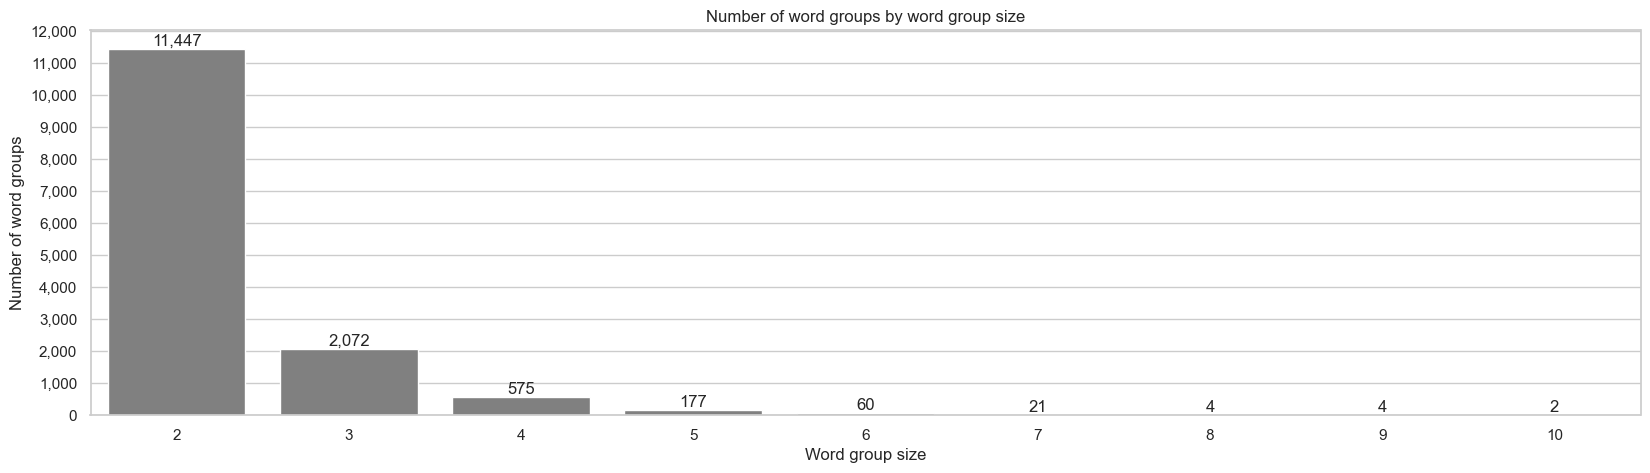

In [119]:
# Create a barplot showing the counts of word groups with at least 2 letters
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))
my_plot = sns.barplot(data = agg_wg_df, x="word_group_count", y="n_words",color = 'Gray')

y_tick_labels = list(range(0, 12001, 1000))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_tick_labels]   

my_plot.set_yticks(ticks = y_tick_labels)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# Annotate bars with values
for c in ax.containers:
    ax.bar_label(c, fmt='{:,.0f}')

#ax.bar_label(ax.containers[0], fontsize=10)
plt.title(label = "Number of word groups by word group size")
plt.xlabel(xlabel = 'Word group size')
plt.ylabel(ylabel = "Number of word groups")

plt.show()